In [48]:
from huggingface_hub import hf_hub_download
import torch
layer = 2
model_id = "Elriggs/pythia-70m-deduped"
# model_id = "Elriggs/pythia-410m-deduped"
ae_download_location = hf_hub_download(repo_id=model_id, filename=f"tied_residual_l{layer}_r6/_63/learned_dicts.pt")
all_autoencoders = torch.load(ae_download_location)
num_l1s = len(all_autoencoders)
all_l1s = [hyperparams["l1_alpha"] for autoencoder, hyperparams in all_autoencoders]
print(all_l1s)
auto_num = 5
autoencoder, hyperparams = all_autoencoders[auto_num]
# You want a hyperparam around 1e-3. Higher is less features/datapoint (at the cost of reconstruction error); lower is more features/datapoint (at the cost of polysemanticity)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to_device(device)
print(hyperparams)

[0.0, 9.999999747378752e-05, 0.00019306977628730237, 0.000372759357560426, 0.0007196856895461679, 0.0013894954463467002, 0.0026826958637684584, 0.005179474595934153, 0.009999999776482582]
{'dict_size': 3072, 'l1_alpha': 0.0013894954463467002}


('# of features above 0.9:', 1502)


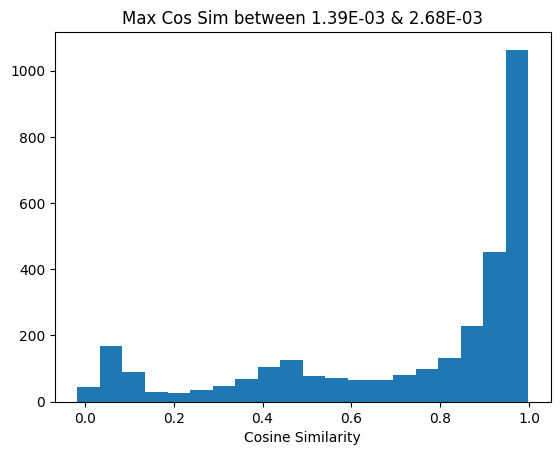

In [49]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import numpy as np
autoencoder_larger, larger_hyperparams = all_autoencoders[auto_num+1]

#Dictionary Comparison
autoencoder_features = hyperparams["dict_size"]
autoencoder_larger_features = larger_hyperparams["dict_size"]
autoencoder_larger.to_device(device)

# Hungary algorithm
# Calculate all cosine similarities and store in a 2D array
cos_sims = np.zeros((autoencoder_features, autoencoder_larger_features))
for idx, vector in enumerate(autoencoder.get_learned_dict()):
    cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), autoencoder_larger.get_learned_dict(), dim=1).cpu().numpy()
# Convert to a minimization problem
cos_sims = 1 - cos_sims
# Use the Hungarian algorithm to solve the assignment problem
row_ind, col_ind = linear_sum_assignment(cos_sims)
# Retrieve the max cosine similarities and corresponding indices
max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

# Get the indices of the max cosine similarities in descending order
max_indices = np.argsort(max_cosine_similarities)[::-1]
max_cosine_similarities[max_indices][:20]
print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))
# Plot histogram of max_cosine_similarities
plt.hist(max_cosine_similarities, bins=20)
plt.xlabel("Cosine Similarity")
plt.title(f"Max Cos Sim between {hyperparams['l1_alpha']:.2E} & {larger_hyperparams['l1_alpha']:.2E}")
plt.show()

In [50]:
from transformer_lens import HookedTransformer
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"

model = HookedTransformer.from_pretrained(model_name, device=device)

if setting == "residual":
    cache_name = f"blocks.{layer}.hook_resid_post"
    neurons = model.cfg.d_model
elif setting == "mlp":
    cache_name = f"blocks.{layer}.mlp.hook_post"
    neurons = model.cfg.d_mlp
elif setting == "attention":
    cache_name = f"blocks.{layer}.hook_attn_out"
    neurons = model.cfg.d_model
elif setting == "mlp_out":
    cache_name = f"blocks.{layer}.hook_mlp_out"
    neurons = model.cfg.d_model
else:
    raise NotImplementedError

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [51]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 40
#TODO: change train[:1000] to train if you want whole dataset
dataset = load_dataset(dataset_name, split="train[:1000]").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


# Get Dictionary Activations

In [52]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
num_features, d_model = autoencoder.encoder.shape
datapoints = dataset.num_rows
batch_size = 32
neuron_activations = torch.zeros((datapoints*token_amount, d_model))
dictionary_activations = torch.zeros((datapoints*token_amount, num_features))
smaller_auto_encoder = autoencoder
smaller_auto_encoder.to_device(device)

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        _, cache = model.run_with_cache(batch.to(device))
        batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
        neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()
        batched_dictionary_activations = smaller_auto_encoder.encode(batched_neuron_activations)
        dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:08<00:00,  3.73it/s]


# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [85]:
from interp_utils import *
# Can sort by MMCS w/ the larger dictionary
# indexed_feature = 13
# best_feature = int(max_indices[indexed_feature])
# Or just random index 
best_feature = 10

text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, model.tokenizer, token_amount, dataset, setting="uniform")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
# visualize_text(full_text, best_feature, model, autoencoder, layer)
visualize_text(text_list, best_feature, model, autoencoder, layer)

In [81]:
ablate_text(text_list, best_feature, model, autoencoder, layer)

In [82]:
ablate_feature_direction_display(full_text, autoencoder, model, layer, features=best_feature)

In [84]:
logit_lens(model, best_feature, autoencoder.get_learned_dict())

['obar', 'osa', 'antly', ' illum', 'ama', 'oku', 'ftware', 'ordo', 'framework', 'gradle', 'ply', ' mant', 'odal', 'ingly', ' brackets', ' hips', ' yoga', ' Yoga', 'student', 'avia']
tensor([1.8662, 1.5685, 1.4807, 1.4003, 1.3656, 1.3377, 1.3342, 1.2819, 1.2748,
        1.2736, 1.2726, 1.2630, 1.2535, 1.2501, 1.2482, 1.2402, 1.2378, 1.2351,
        1.2312, 1.2129])
